In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
tar_path = '/content/drive/MyDrive/segmentation-project/neurite-oasis.v1.0.tar'
extract_path = '/content/segmentation_data'
os.makedirs(extract_path, exist_ok=True)

# Extract if needed
!tar -xf "{tar_path}" -C "{extract_path}"

In [ ]:
# Overwrite seg4_paths.txt with updated correct paths
with open("seg4_paths_copy.txt", "r") as f:
    lines = f.readlines()

with open("seg4_paths_copy.txt", "w") as f:
    for line in lines:
        updated = line.replace("neurite-oasis.v1.0", "segmentation_data")
        f.write(updated)

print("✅ Done! seg4_paths_copy.txt now uses 'segmentation_data'.")

✅ Done! seg4_paths_copy.txt now uses 'segmentation_data'.


In [ ]:
!python convert_one_hot.py --txt_path seg4_paths_copy.txt

Processing segmentation maps: 100% 414/414 [03:55<00:00,  1.76it/s]


In [ ]:
import os

# Check if one-hot file exists for first subject
print("Sample file:", os.listdir("segmentation_data/OASIS_OAS1_0395_MR1"))

Sample file: ['slice_orig.nii.gz', 'orig.nii.gz', 'slice_seg4.nii.gz', 'slice_norm.nii.gz', 'slice_seg24.nii.gz', 'norm.nii.gz', 'aligned_norm.nii.gz', 'aligned_seg35.nii.gz', 'seg4_onehot.npy', 'aligned_orig.nii.gz', 'aligned_seg4.nii.gz', 'seg4.nii.gz', 'seg35.nii.gz']


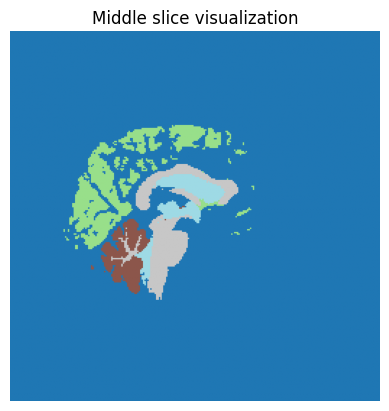

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('segmentation_data/OASIS_OAS1_0016_MR1/seg4_onehot.npy')
middle_slice = data.argmax(axis=0)[data.shape[1] // 2]
plt.imshow(middle_slice, cmap='tab20')
plt.title("Middle slice visualization")
plt.axis('off')
plt.show()

In [ ]:
!python train.py --train_txt /content/drive/MyDrive/segmentation-project/train_split.txt --template_path segmentation_data/OASIS_OAS1_0016_MR1/seg4_onehot.npy --batch_size 1 --epochs 50

Streaming output truncated to the last 5000 lines.
Cross-entropy: 0.907616
Training for epoch: 44/50:  71% 278/394 [08:03<03:21,  1.73s/it]Dice Loss: 0.0292
Cross-entropy: 0.907953
Training for epoch: 44/50:  71% 279/394 [08:05<03:19,  1.73s/it]Dice Loss: 0.0302
Cross-entropy: 0.908404
Training for epoch: 44/50:  71% 280/394 [08:07<03:18,  1.74s/it]Dice Loss: 0.0186
Cross-entropy: 0.906903
Training for epoch: 44/50:  71% 281/394 [08:08<03:16,  1.74s/it]Dice Loss: 0.0245
Cross-entropy: 0.907649
Training for epoch: 44/50:  72% 282/394 [08:10<03:15,  1.74s/it]Dice Loss: 0.0284
Cross-entropy: 0.908808
Training for epoch: 44/50:  72% 283/394 [08:12<03:13,  1.74s/it]Dice Loss: 0.0336
Cross-entropy: 0.909277
Training for epoch: 44/50:  72% 284/394 [08:14<03:11,  1.74s/it]Dice Loss: 0.0243
Cross-entropy: 0.909203
Training for epoch: 44/50:  72% 285/394 [08:15<03:09,  1.74s/it]Dice Loss: 0.0221
Cross-entropy: 0.907275
Training for epoch: 44/50:  73% 286/394 [08:17<03:07,  1.74s/it]Dice Loss: 0.

In [ ]:
from get_data import SegDataset
from model import UNet, SpatialTransformer
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Updated paths - use train split instead of full dataset
train_txt_path = '/content/drive/MyDrive/segmentation-project/train_split.txt'
template_path = 'segmentation_data/OASIS_OAS1_0016_MR1/seg4_onehot.npy'
model_path = 'checkpoints/original_unet_model.pth'

# Re-create dataset and dataloader with TRAIN SPLIT ONLY
train_dataset = SegDataset(train_txt_path, template_path)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)

print(f"📊 Training dataset loaded: {len(train_dataset)} samples (train split only)")
print(f"🔒 Test set is safely locked away for final evaluation!")

# Re-create your model (UNet + SpatialTransformer)
model = UNet(in_channels=10, out_channels=3).to(device)
stn = SpatialTransformer(size=(128,128,128), device=device).to(device)

# Load the trained model
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Model loaded successfully!")

📊 Training dataset loaded: 394 samples (train split only)
🔒 Test set is safely locked away for final evaluation!
Model loaded successfully!


In [ ]:
sample_batch = next(iter(train_loader))
moving, fixed = sample_batch
moving = moving.to(device)
fixed = fixed.to(device)

with torch.no_grad():
    # 1. Concatenate moving and fixed as input to UNet
    input_ = torch.cat([moving, fixed], dim=1)  # Shape: (B, 10, 128, 128, 128)

    # 2. Get deformation field from UNet
    deformation_field = model(input_)

    # 3. Apply deformation using SpatialTransformer
    warped_template = stn(moving, deformation_field)

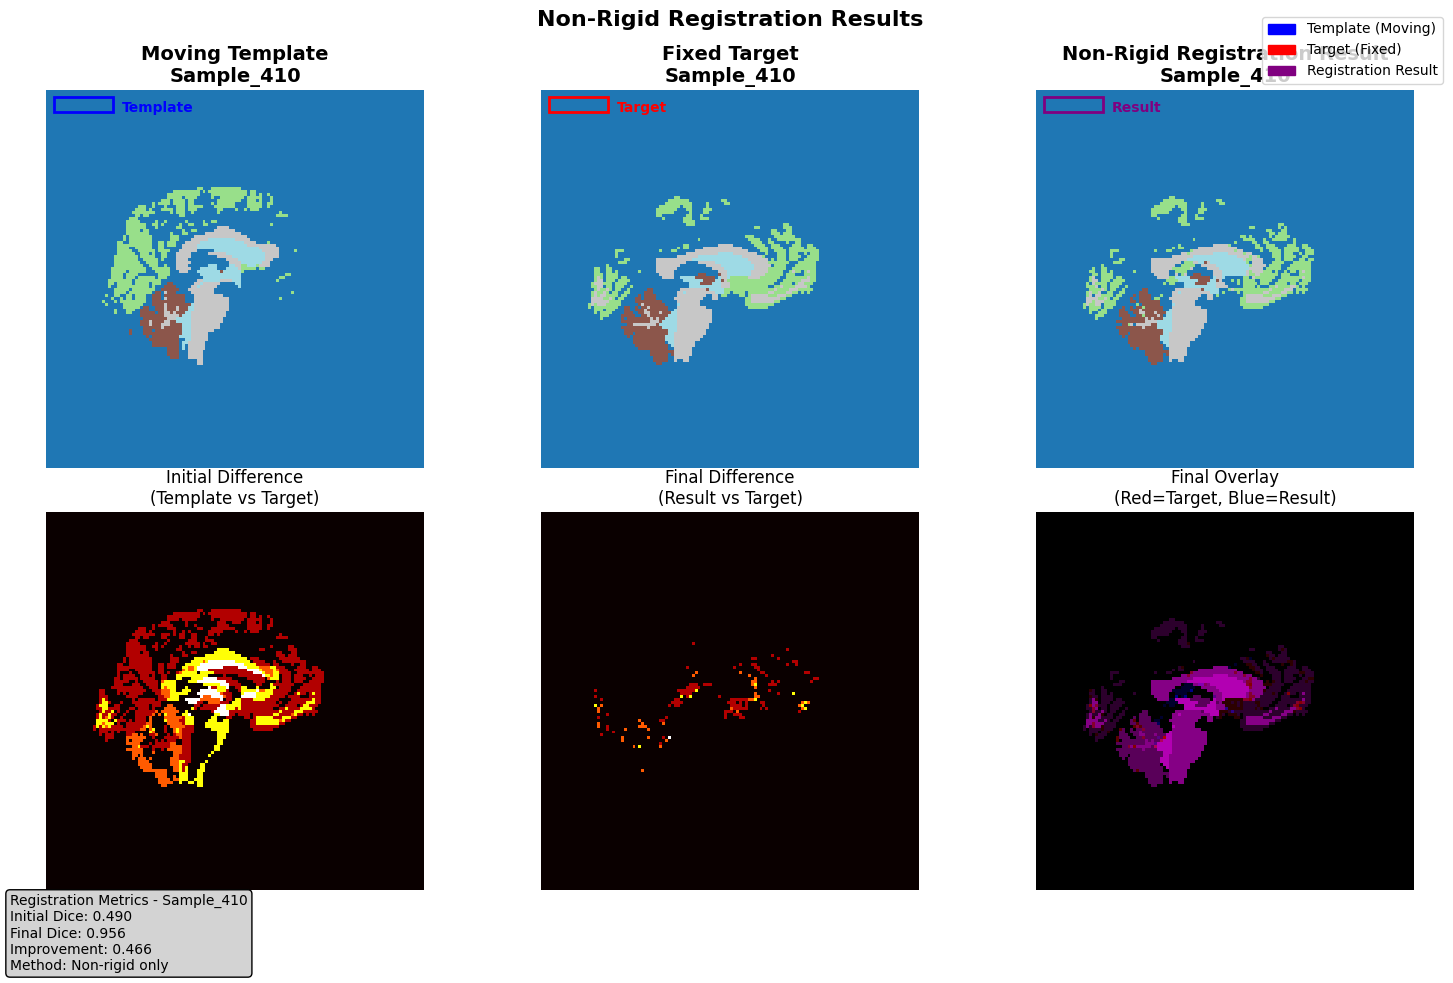

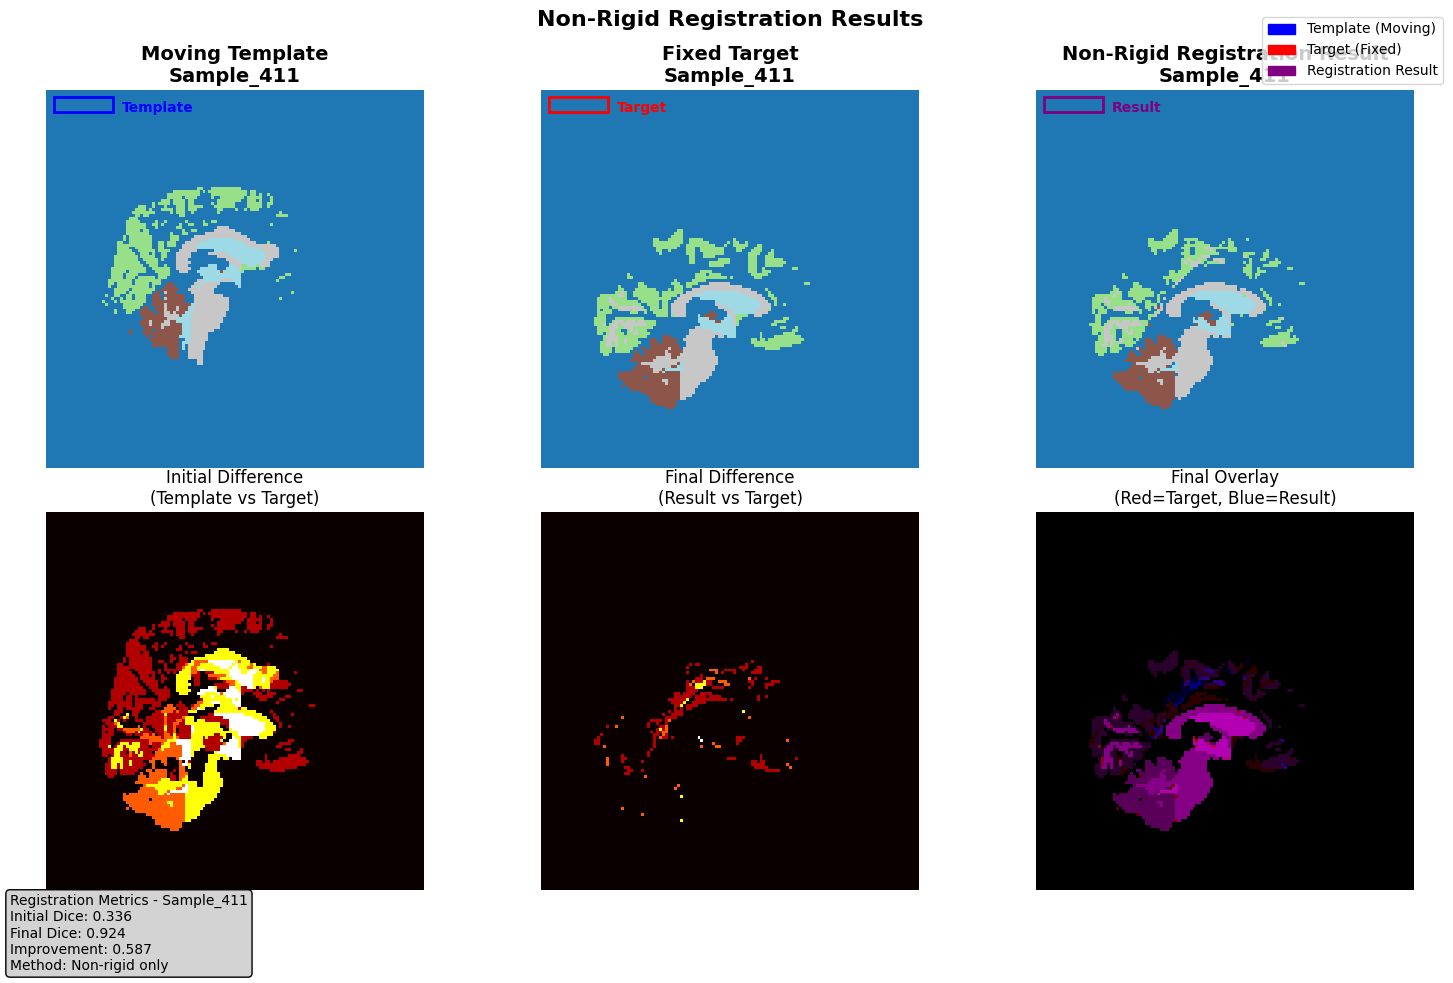

In [ ]:
from visualize import visualize_registration_colab
visualize_registration_colab(moving, fixed, warped_template)

In [ ]:
!cp checkpoints/original_unet_model.pth /content/drive/MyDrive/segmentation-project/

print("Model saved to Google Drive successfully!")

Model saved to Google Drive successfully!
